# Actor-Critic - Sequential

##### Imports

In [1]:
import numpy as np
import einops as ein
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from kilroyplot.plot import plt
from tqdm import tqdm

##### Utilities

In [2]:
def squash_packed(x, fn):
    return rnn.PackedSequence(fn(x.data), x.batch_sizes, x.sorted_indices, x.unsorted_indices)

def unpad_sequence(x, lengths):
    return [s[:length] for s, length in zip(x, lengths)]

## Reward function

In [3]:
evaluate = lambda x: -1 if len(x) > 3 else x.count(4)

## Model

In [4]:
class Actor(nn.Module):
    """Predicts probabilities of next action being the best for each action in sequence."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        is_packed = isinstance(x, rnn.PackedSequence)
        x = squash_packed(x, self.embedding) if is_packed else self.embedding(x)
        out, _ = self.lstm(x)
        y = squash_packed(out, self.linear) if is_packed else self.linear(out)
        return squash_packed(y, lambda yf: F.softmax(yf, dim=-1)) if is_packed else F.softmax(y, dim=-1)

In [5]:
class Critic(nn.Module):
    """Predicts reward for given sequence of actions."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = squash_packed(x, self.embedding) if isinstance(x, rnn.PackedSequence) else self.embedding(x)
        _, (ht, _) = self.lstm(x)
        return self.linear(ht[-1])

In [6]:
class Generator:
    """Generates sequence of actions using actor until end action of max length exceeding."""
    
    def __init__(self, model, start_word, end_word, pad_word, max_length):
        self.model = model
        self.start_word = start_word
        self.end_word = end_word
        self.pad_word = pad_word
        self.max_length = max_length
        
    def generate(self, n=1):
        out = []
        x = torch.tensor([[self.start_word]] * n)
        i = 1
        while len(x) > 0 and i < self.max_length:
            batched_probs = self.model(x)[:, -1]
            next_words = self.pick_words(batched_probs)
            x = torch.cat((x, next_words.unsqueeze(-1)), dim=-1)
            # add all sequences that ended to out, process all other sequences
            # this way we can process sequences in batches
            finished_mask = next_words == self.end_word
            finished = x[finished_mask]
            out.extend(list(finished))
            x = x[~finished_mask]
            i += 1
        out.extend(list(x))
        out = sorted(out, key=lambda s: len(s), reverse=True)
        lengths = [len(s) for s in out]
        out = rnn.pad_sequence(out, batch_first=True, padding_value=self.pad_word)
        return rnn.pack_padded_sequence(out, lengths, batch_first=True)  # return as PackedSequence
    
    def pick_words(self, batched_probs):
        return torch.tensor([Categorical(probs).sample() for probs in batched_probs])

## Learning

Critic learns rewards for sequences of actions generated from actor by supervised learning. Actor learns to give higher probability to actions rated high by critic by Policy Gradients.

The assumption is that evaluating real rewards is costly, so critic should learn to evaluate as quickly as possible. Then we can use critic to evaluate actions sampled from actor and teach actor using that.

In [7]:
start_word, stop_word, pad_word = 1, 2, 0
vocab_size = 3 + 2
max_length = 5
embedding_dim, hidden_dim, out_dim = 16, 16, vocab_size

In [8]:
actor = Actor(vocab_size, embedding_dim, hidden_dim, out_dim)
critic = Critic(vocab_size, embedding_dim, hidden_dim)

In [9]:
generator = Generator(actor, start_word, stop_word, pad_word, max_length)

In [10]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

In [11]:
epochs = 1000
actor_iters = 1
actor_batch_size = 64
critic_iters = 1
critic_batch_size = 64

In [12]:
def train_critic(actor, critic, generator, iters, batch_size, optimizer, evaluate, pad_word):
    losses = []
    optimizer.zero_grad()
    for _ in range(iters):
        sentences = generator.generate(batch_size)
        pred_rewards = critic(sentences)
        padded_sentences, lengths = rnn.pad_packed_sequence(sentences, batch_first=True, padding_value=pad_word)
        real_rewards = torch.tensor([evaluate(s.tolist()) for s in unpad_sequence(padded_sentences, lengths)]).unsqueeze(-1).float()
        loss = nn.MSELoss()(pred_rewards, real_rewards)
        loss.backward()
        losses.append(loss.item())
    optimizer.step()
    return np.mean(losses)

def train_actor(actor, critic, generator, iters, batch_size, optimizer):
    losses, rewards = [], []
    optimizer.zero_grad()
    for _ in range(iters):
        sentences = generator.generate(batch_size)
        predicted_rewards = critic(sentences)
        preds = actor(sentences)
        sentences_padded, sentences_lengths = rnn.pad_packed_sequence(sentences, batch_first=True)
        preds_padded, preds_lengths = rnn.pad_packed_sequence(preds, batch_first=True)
        probs = [
            torch.gather(p[:-1], -1, s[1:].unsqueeze(-1)).squeeze(-1)
            for s, p in zip(
                unpad_sequence(sentences_padded, sentences_lengths),
                unpad_sequence(preds_padded, preds_lengths)
            )
        ]
        loss = torch.cat([
            -(r * torch.log(p).sum())
            for p, r in zip(probs, predicted_rewards)
        ]).mean()
        loss.backward()
        losses.append(loss.item())
        rewards.append(predicted_rewards.mean().item())
    optimizer.step()
    return np.mean(losses), np.mean(rewards)

In [13]:
critic_losses, actor_losses, actor_rewards = [], [], []

for i in tqdm(range(epochs)):
    loss = train_critic(actor, critic, generator, critic_iters, critic_batch_size, critic_optimizer, evaluate, pad_word)
    critic_losses.append(loss)
    
    loss, reward = train_actor(actor, critic, generator, actor_iters, actor_batch_size, actor_optimizer)
    actor_losses.append(loss)
    actor_rewards.append(reward)

100%|██████████| 1000/1000 [01:41<00:00,  9.81it/s]


## Results

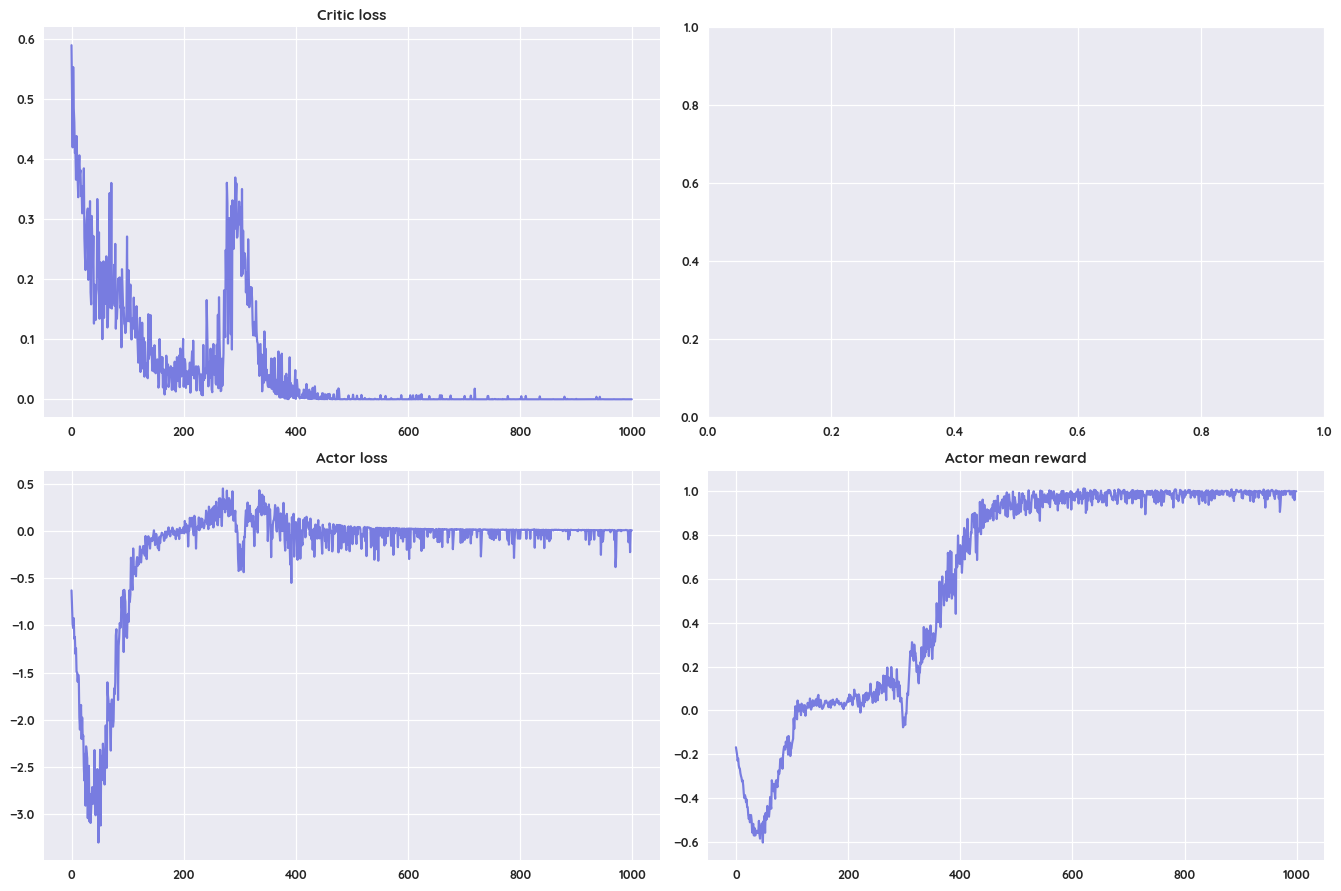

In [14]:
_, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].plot(critic_losses)
axs[0][0].set_title("Critic loss")
axs[1][0].plot(actor_losses)
axs[1][0].set_title("Actor loss")
axs[1][1].plot(actor_rewards)
axs[1][1].set_title("Actor mean reward")
plt.tight_layout()

In [15]:
padded_sentences, lengths = rnn.pad_packed_sequence(generator.generate(20), batch_first=True, padding_value=pad_word)
for sentence in unpad_sequence(padded_sentences, lengths):
    batched_sentence = sentence.unsqueeze(0)
    reward = critic(batched_sentence)[0].item()
    real_score = evaluate(sentence.tolist())
    preds = actor(batched_sentence)
    probs = torch.gather(preds, -1, batched_sentence.unsqueeze(-1)).squeeze(-1)
    loss = -(reward * torch.log(probs).sum()).item()
    print(f"Sentence: {sentence.tolist()}, critic score, {reward:.3f}, real score: {real_score:.3f}, loss: {loss:.3f}")

Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.999, real score: 1.000, loss: 15.109
Sentence: [1, 4, 2], critic score, 0.9